# Single galaxy Prospector run

Try to run Prospector on a galaxy from Chang's catalog and compare to known stellar mass / redshift values.

First, load in the imports:

In [1]:
import sedpy 
import prospect
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt

import prospect.io.read_results as reader
from prospect.models import SpecModel, SedModel, priors
from prospect.sources import CSPSpecBasis
from prospect.fitting import lnprobfn, fit_model
from prospect.models.templates import TemplateLibrary
import matplotlib as mpl

Some styling choices to make our plots look nicer, not really important (but you can read about Matplotlib's RC parameters [here](https://matplotlib.org/stable/users/explain/customizing.html))

In [2]:
styling = {
        'lines.linewidth' : 2,
        'font.family' : 'sans-serif',
        'axes.labelsize' : 15,
        'legend.fontsize' : 15,
        'font.size' : 15,
        "xtick.labelsize": 15,
        "ytick.labelsize": 15,
        'ytick.major.size' : 8,
        'ytick.minor.size' : 4,
        'xtick.major.size' : 10,
        'xtick.minor.size' : 6,
        'xtick.direction' : 'inout',
        'ytick.direction' : 'inout',  
}

mpl.rcParams.update(styling)

Test all the code on one example galaxy:

In [3]:
gal_id = 33

## Load the data

Load the data and look at a single galaxy. We use AstroPy's [fits](https://docs.astropy.org/en/stable/io/fits/) module to read in the FITS file, load the AstroPy [table](https://docs.astropy.org/en/stable/table/) from the FITS file, and then convert the table to a [pandas DataFrame](https://pandas.pydata.org/) because they are less annoying to deal with.

In [4]:
with fits.open('data/sw_input.fits') as f:
    df = Table(f[1].data).to_pandas()
    f.close()

### Build an observation

As suggested by [Prospector docs](https://prospect.readthedocs.io/en/latest/dataformat.html), it's good to wrap all the functions needed to load in & organize the data before Prospector run in a single function. Here we take a row from the dataframe for a given object, convert all the fluxes to maggies, and build the dictionary taken as a prospector input. The dictionary keys we need to populate are:

* `filters` : a list of `N` `sedpy` response filters for each object
* `redshift`: (optional) known redshift 
* `maggies` : `Nx1` array of flux densities for the object. $1\:\textrm{maggie} = 10^{-0.4 m_{AB}} = f_{Jy} /3631$
* `maggies_unc`: `Nx1` array with associated uncertainties in the same units

Optional keys:
* `phot_mask` : `Nx1` array corresponding to each magnitude; `True` **if the value should be used** and `False` **if it should be masked**.

Some things to note:

* Everything in the Chang catalog is in Janskys, so we can convert to Janskys
* We use `flux_x` instead of `flux0_x` values b/c they are corrected for galactic extinction

In [5]:
def build_obs(gal_id):
    """Given an object, load in fluxes, convert them to nanomaggies, and create a dict used in Prospector."""

    inp = {}
    
    # Get dataframe row for the object
    row = df.iloc[gal_id]
    inp['redshift'] = row.redshift

    # Load the filter response curves from sedpy
    bands = [f'sdss_{filt}0' for filt in 'ugriz'] + [f'wise_w{n}' for n in range(1,5)]
    filters = sedpy.observate.load_filters(bands)
    inp['filters'] = filters
    
    # Fluxes and uncertainties - already in units of maggies
    cols = [f'flux_{filt}' for filt in 'ugriz'] + [f'flux_w{n}' for n in range(1,5)]
    fluxes = row[cols].values.astype(float) / 3631

    # Errors
    cols_err = [f'{col}_e' for col in cols]
    errs = row[cols_err].values.astype(float) / 3631

    # Anything with a value of 9.999 is null, so may need to mask those fluxes by editing phot_mask
    inp['maggies'] = fluxes
    inp['maggies_unc'] = errs
    inp['phot_mask'] = [True for val in fluxes] # Nothing masked here right now

    # This is an array of effective wavelengths for each of the filters.  
    # It is not necessary, but it can be useful for plotting so we store it here as a convenience
    inp["phot_wave"] = np.array([f.wave_effective for f in inp["filters"]])
    inp["wavelength"] = None
    
    # Populate other fields with default
    inp = prospect.utils.obsutils.fix_obs(inp)
    return inp

Run on the example galaxy:

In [6]:
obs = build_obs(gal_id)

Plot the observational data and the bandpass curves:

Obs Dictionary Keys:

dict_keys(['redshift', 'filters', 'maggies', 'maggies_unc', 'phot_mask', 'phot_wave', 'wavelength', 'spectrum', 'unc', 'filternames', 'logify_spectrum', 'ndof'])

--------
Filter objects:

[<class 'sedpy.observate.Filter'>(sdss_u0), <class 'sedpy.observate.Filter'>(sdss_g0), <class 'sedpy.observate.Filter'>(sdss_r0), <class 'sedpy.observate.Filter'>(sdss_i0), <class 'sedpy.observate.Filter'>(sdss_z0), <class 'sedpy.observate.Filter'>(wise_w1), <class 'sedpy.observate.Filter'>(wise_w2), <class 'sedpy.observate.Filter'>(wise_w3), <class 'sedpy.observate.Filter'>(wise_w4)]


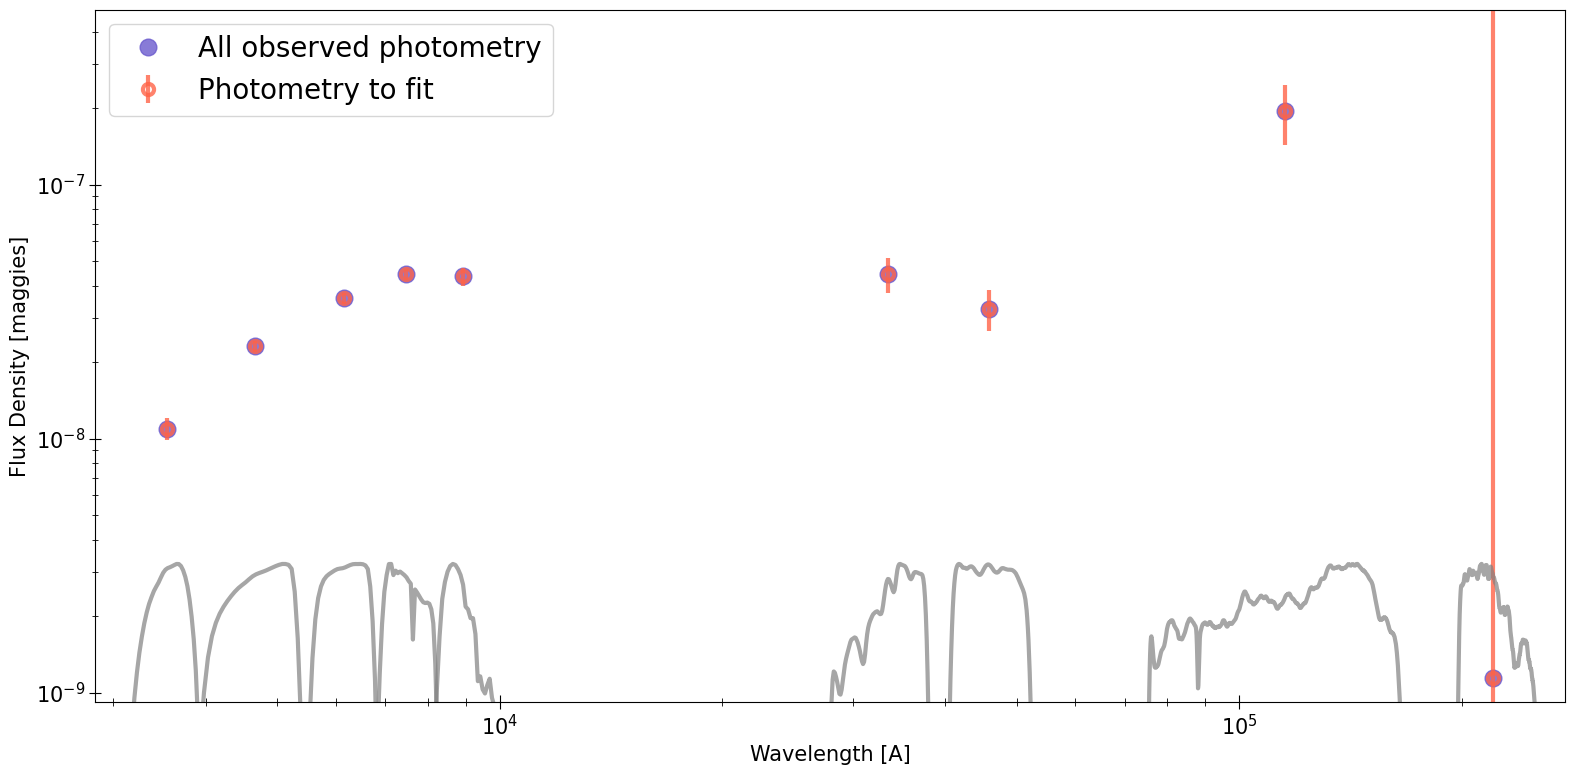

In [7]:

# Look at the contents of the obs dictionary
print("Obs Dictionary Keys:\n\n{}\n".format(obs.keys()))
print("--------\nFilter objects:\n")
print(obs["filters"])

# --- Plot the Data ----
# This is why we stored these...
wphot = obs["phot_wave"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*0.8, obs["maggies"].max()/0.4
plt.figure(figsize=(16,8))

# plot all the data
plt.plot(wphot, obs['maggies'],
     label='All observed photometry',
     marker='o', markersize=12, alpha=0.8, ls='', lw=3,
     color='slateblue')

# overplot only the data we intend to fit
mask = obs["phot_mask"]
plt.errorbar(wphot[mask], obs['maggies'][mask], 
         yerr=obs['maggies_unc'][mask], 
         label='Photometry to fit',
         marker='o', markersize=8, alpha=0.8, ls='', lw=3,
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    plt.loglog(w, t, lw=3, color='gray', alpha=0.7)

# prettify
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xscale("log")
plt.yscale("log")
plt.legend(loc='best', fontsize=20)
plt.tight_layout()

## Build model

Next, we have to build a model to fit the SED with. Decision in this step can significantly affect the resulting SED, and there are many things that we could change! The [tutorial](https://prospect.readthedocs.io/en/latest/tutorial.html) has a large section on selecting the model, and the [Models](https://prospect.readthedocs.io/en/latest/models.html) section of the docs has more information.

For the project, we fit a simple model. All different models live in the `TemplateLibrary` directory, and can be viewed with `TemplateLibrary.show_contents()`.

Here we pick a simple parametric SFH model `parametric_sfh`  for a delay-tau SFH. We can add more complicated free parameters, e.g. nebular emission lines, with 

    model_params = TemplateLibrary["parametric_sfh"]
    nebular_params = TemplateLibrary["nebular"]
    model_params.update(nebular_params)

This will replace any keys in the parametric model with the new keys from the nebular model, and add any missing keys as well. Similarly, we can add things like AGN (`agn`), IGM (`igm`), or choose different SFH assumptions.

The model will have many parameters, where some are fixed and some are free to vary (`free: False` or `free: True`). Free parameters need to have an associated [prior](https://prospect.readthedocs.io/en/latest/api/models_api.html#module-prospect.models.priors).

For a simple test, try the **default parameters**

* Parametric SFH (`parametric_sfh`), where $\textrm{SFR} \sim t_{age} e^{-t_{age} / \tau}$
* No nebular, dust, or AGN emission
* Fixed redshift, IMF type, dust type, FSPS SFH model (default values)
    * Redshift `zred`: will given by the spectroscopic redshift
    * SFH model  `sfh`: delayed-tau model from [SFPS](https://github.com/cconroy20/fsps/blob/master/doc/MANUAL.pdf)
    * Dust model `dust_type`: uniform screen dust model from FSPS with a Calzetti dust attenuation
    * IMF model `imf_type`: **can't find any info on this in the docs**
* Varying parameters: mass, metallicity, dust, $t_{age}$, $\tau$
    * Mass prior: log-normal between $8 < \log M < 12$, initial guess $\log M_0 = 10$
    * Metallicity prior: tophat between $-2 < \log Z/Z_\odot < 0.19$, initial guess $\log Z_0/Z_\odot = -0.5$
    * Dust optical depth prior: tophat between $0 < \kappa < 2$, initial guess $\kappa_0 = 0.6$
    * SFR decay timescale: $0.1 < \tau < 30$ Gyr$^{-1}$, initial guess $\tau_0 = 1$ Gyr$^{-1}$
    * SFR time: $0.001 < t_{age} < 13.8$, initial guess $t_{age, 0} = 1$ Gyr
 


### SED vs Spec Model

With these parameters, we have two choices: we can either fit an SED-only model, or a spectroscopic model. Depending on your use case, you should use `SedModel` or `SpecModel` respectively. The spectroscopic model is needed if you are trying to fit nebular emission or dust emission/absorption lines. For this example, since we are fitting a very simple model, we use `SedModel`.


In [8]:
model_params = TemplateLibrary["parametric_sfh"]

# Set the redshift to known spec-z
model_params["zred"]["init"] = obs["redshift"]

# Alternatively: we can let redshift vary if it's not known
# model_params["zred"]["isfree"] = True
# model_params['zred']['init'] = 0.1
# model_params['zred']['prior'] = priors.TopHat(mini=0,maxi=1)

# Build the model
model = SedModel(model_params)

## Build SPS 

Here we define the stellar population synthesis object. From the [docs](https://prospect.readthedocs.io/en/latest/tutorial.html#):

> For nonparameteric fits one would use the sources.FastStepBasis object. These objects hold all the spectral libraries and produce an SED given a set of parameters.

    :param zcontinuous: 
        A vlue of 1 insures that we use interpolation between SSPs to 
        have a continuous metallicity parameter (`logzsol`)
        See python-FSPS documentation for details
        
At this stage, we could also define some more complicated noise models for our spectroscopic and photometric measurements - but for now we skip this step, assuming all uncertainties are independent and Gaussian.

In [9]:
sps = CSPSpecBasis(zcontinuous=1)

### Plot the initial fit 

(It will be bad as it's not optimized)

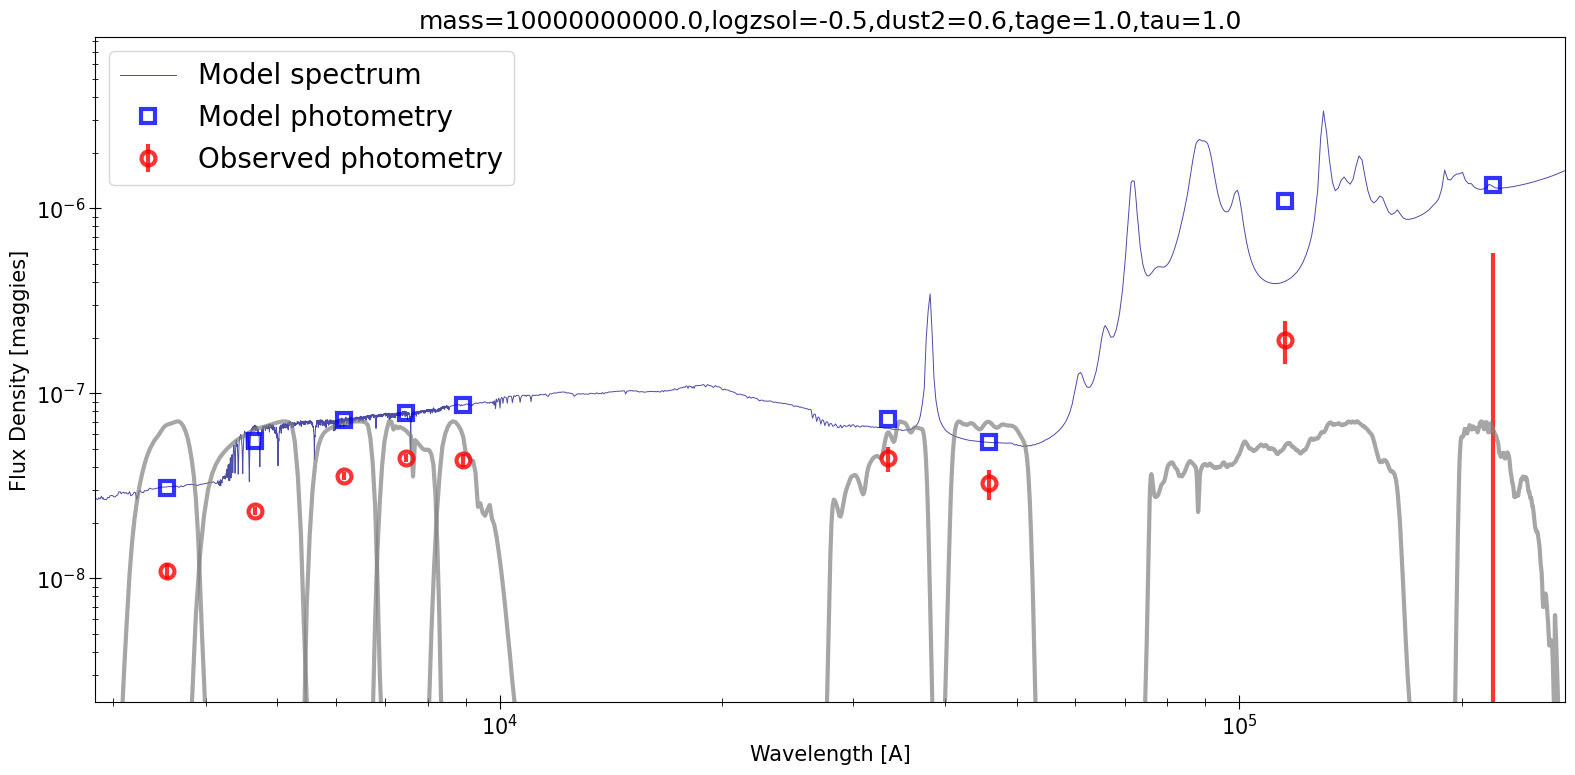

In [10]:
# Generate the model SED at the initial value of theta
theta = model.theta.copy()
initial_spec, initial_phot, initial_mfrac = model.sed(theta, obs=obs, sps=sps)
title_text = ','.join(["{}={}".format(p, model.params[p][0]) 
                       for p in model.free_params])

a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
# photometric effective wavelengths
wphot = obs["phot_wave"]
# spectroscopic wavelengths
# *restframe* spectral wavelengths, since obs["wavelength"] is None
wspec = sps.wavelengths
wspec *= a #redshift them


# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, initial_spec)
ymin, ymax = temp.min()*0.8, temp.max()/0.4
plt.figure(figsize=(16,8))

# plot model + data
plt.loglog(wspec, initial_spec, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
plt.errorbar(wphot, initial_phot, label='Model photometry', 
         marker='s',markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
plt.errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry',
         marker='o', markersize=10, alpha=0.8, ls='', lw=3,
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)
plt.title(title_text)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    plt.loglog(w, t, lw=3, color='gray', alpha=0.7)

# prettify
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([ymin/10, ymax])
plt.legend(loc='best', fontsize=20)
plt.tight_layout()

## Running a fit

There are various MCMC samplers available by Prospector and we can input our custom samplers. The two common ones are `emcee` (ensemble sampling) and `dynesty` (dynamic nested sampling). The fitting is done using the `fit_model` function, with parameters

* `obs` : the observation dict made with `build_obs`
* `model`: the model we built
* `sps`: sps defined above
* `noise` : noise model for (specdata, photdata) - by default (None, None) uses independent Gaussian noise
* `lnprobfn`: posterior probability function, can use the default for now
* `run_params`: any additional keyword arguments we want to pass to the sample

### Run parameters
Here we can decide on the parameters used by the samplers. The parameters differ, depending on if you are choosing emcee or dynasty.

* `emcee`: if True, use the emcee sampler (controlled by fitting kwargs)
* `dynesty`: if True, use the dynesty sampler (controlled by fitting kwargs)

### Emcee parameters
* `nwalkers` : the number of MCMC chains that start simultaneously
* `niter` : number of tierations of the MCMC sampling
* `optimize`:  if True, run a round of optimization before sampling, the optimization params can be controlled by keyword args.
* `nburn` : number of iterations in each round of burn-in. After each round, the walkers are reinitialized based on the locations of the highest probability half of the walkers.


In [11]:
run_params = {}
run_params["optimize"] = True
run_params["emcee"] = True
run_params["dynesty"] = False
run_params["nwalkers"] = 128
run_params["niter"] = 512
run_params["nburn"] = [16, 32, 64]

Finally, run the fit. <font color=#c00>**This will take some time!**</font>

In [12]:
output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params)
print('done emcee in {0}s'.format(output["sampling"][1]))

/home/justin/.local/lib/python3.10/site-packages/prospect/models/priors.py:117: RuntimeWarning: divide by zero encountered in log
  lnp = np.log(p)


number of walkers=128
done burn #0 (16 iterations)
done burn #1 (32 iterations)
done burn #2 (64 iterations)
number of walkers=128
starting production
done production
done emcee in 413.43386459350586s


### Save the fit to a file
Be careful: if a file with the name `hfile` already exists, Prospector will save the new output to a new location with a datetime stamp. So simply reading the results in using `reader.results_from...` in the following block may not work. In general, be aware of the filenames your code outputs!

The output is in the HDF5 format which is generally useful if you have large datasets. HSF5 files use binary encoding to compress data, and follow a root structure similar to your computer within the file. One cool thing about them is that opening an HDF5 file *does not read all of it into memory* but allows you to perform operations on subsections of the file. For example, if you have a 10GB simulation volume spanning 100 Mpc but you only want to read in the data around your galaxy, you can index the necessary region of the array and Python will only actually *load* that region. You can read more about the Python implementation of HDF5 - the [h5py package](https://www.h5py.org/).

In [13]:
result, duration = output["sampling"]
from prospect.io import write_results as writer

# Name of the output file
results_type = "emcee" # | "dynesty"
hfile = f"output/gal{gal_id}_{results_type}.h5"

writer.write_hdf5(hfile, run_params, model, obs,
                 output["sampling"][0], output["optimization"][0],
                 sps=sps,
                 tsample=output["sampling"][1],
                 toptimize=output["optimization"][1])


/home/justin/.local/lib/python3.10/site-packages/prospect/io/write_results.py:60: RuntimeWarning: Could not store paramfile text
  warnings.warn("Could not store paramfile text", RuntimeWarning)
/home/justin/.local/lib/python3.10/site-packages/prospect/io/write_results.py:301: RuntimeWarning: Could not JSON serialize model_params, pickled instead
  warnings.warn("Could not JSON serialize {}, pickled instead".format(k),
/home/justin/.local/lib/python3.10/site-packages/prospect/io/write_results.py:49: RuntimeWarning: Could not obtain prospector version info
  warnings.warn("Could not obtain prospector version info", RuntimeWarning)


### Read in the file & plot diagnostic plots

Here we read in our HDF5 output file (again, be careful of file names). 

In [14]:
import prospect.io.read_results as reader

results_type = "emcee" # | "dynesty"
hfile = 'output/gal33_emcee.h5' # The filename should be changed

# Grab results (dictionary), the obs dictionary, and our corresponding models
# When using parameter files set `dangerous=True`
#result, obs, model = reader.results_from(hfile)
result, obs, ___ = reader.results_from(hfile)


# The following commented lines reconstruct the model and sps object, 
# if a parameter file continaing the `build_*` methods was saved along with the results
#model = reader.get_model(result)
#sps = reader.get_sps(result)

# let's look at what's stored in the `result` dictionary
print(result.keys())


dict_keys(['model_params', 'optimizer_duration', 'paramfile_text', 'prospector_version', 'run_params', 'acceptance', 'chain', 'initial_theta', 'lnprobability', 'sampling_initial_center', 'rstate', 'sampling_duration', 'theta_labels', 'bestfit', 'optimization', 'obs', 'model'])


#### Trace figure

Shows how the values for all the parameters change for a subset of (`size=`) 10 walkers with each iteration

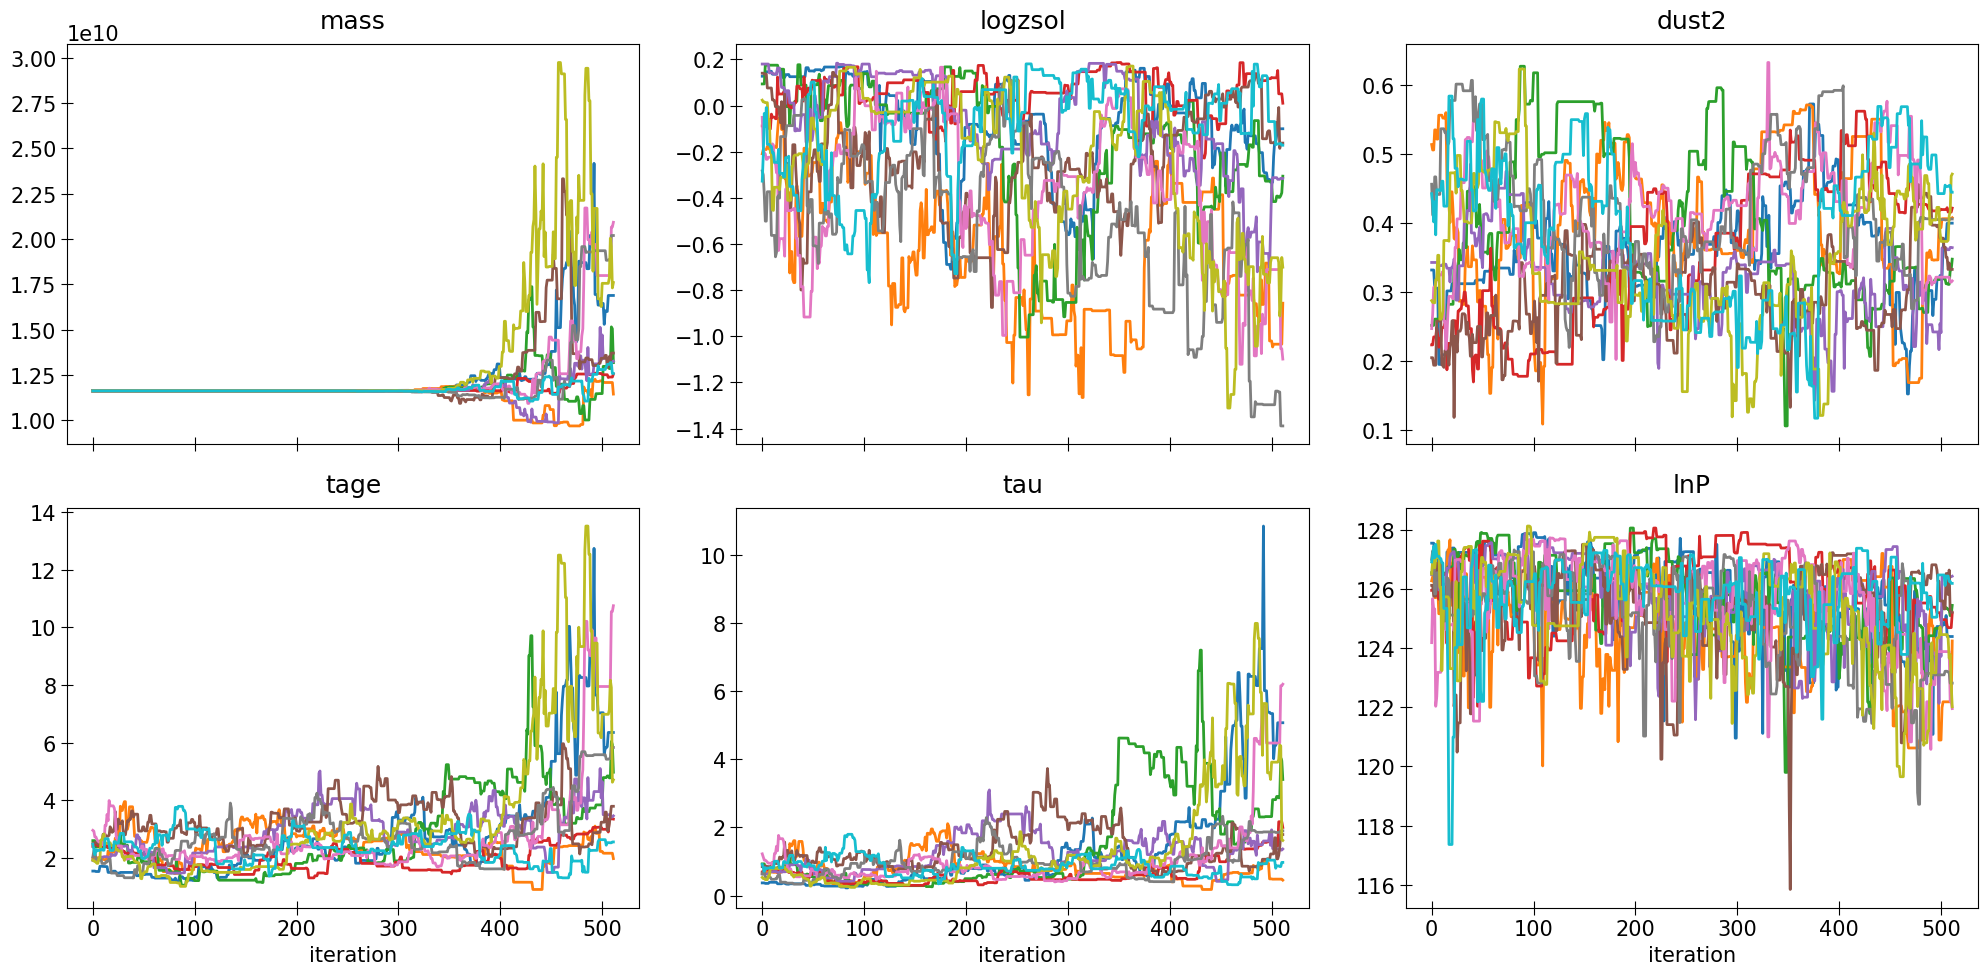

In [15]:
if results_type == "emcee":
    chosen = np.random.choice(result['run_params']["nwalkers"], size=10, replace=False)
    tracefig = reader.traceplot(result, figsize=(20,10), chains=chosen)
else:
    tracefig = reader.traceplot(result, figsize=(20,10))


#### Best SED fit

Here we plot the SED provided by our best fit (MAP, or maximum a posteriori sample, in green) as well as some random walker (in blue) 

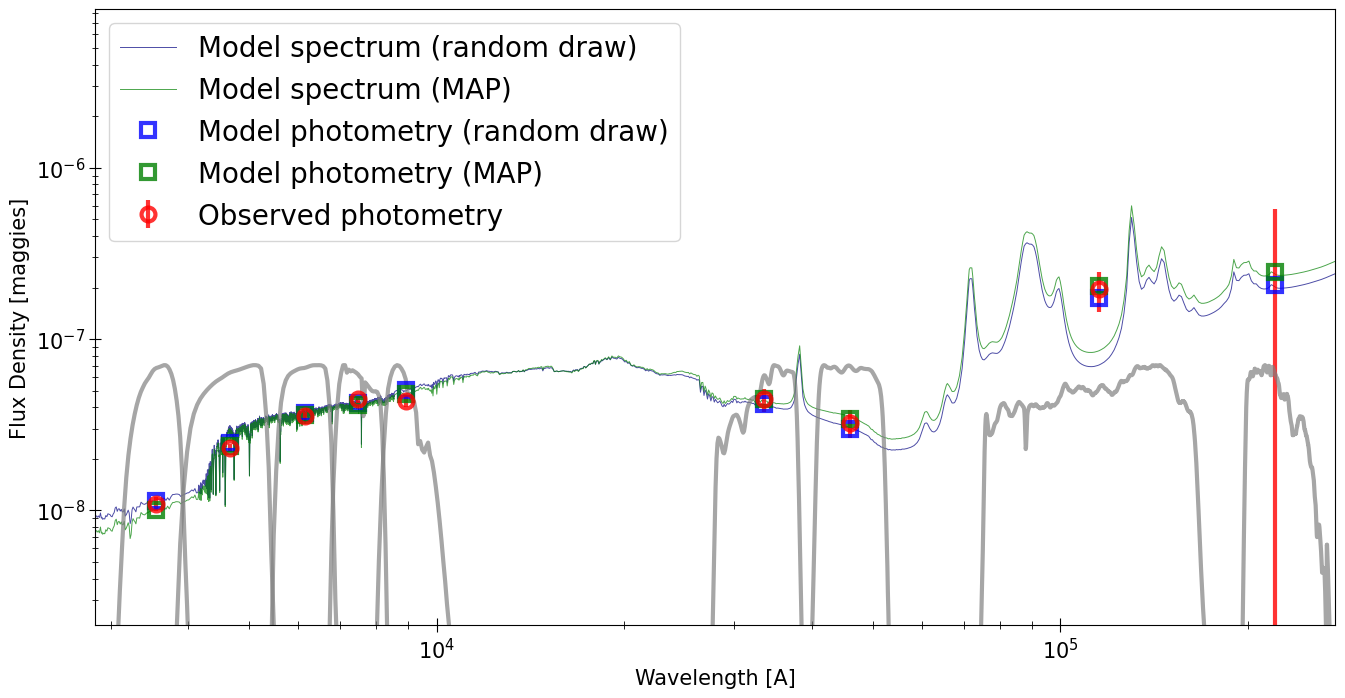

In [16]:
# maximum a posteriori (of the locations visited by the MCMC sampler)
imax = np.argmax(result['lnprobability'])

if results_type == "emcee":
    i, j = np.unravel_index(imax, result['lnprobability'].shape)
    theta_max = result['chain'][i, j, :].copy()
    thin = 5
else:
    theta_max = result["chain"][imax, :]
    thin = 1


# randomly chosen parameters from chain
randint = np.random.randint
if results_type == "emcee":
    nwalkers, niter = run_params['nwalkers'], run_params['niter']
    theta = result['chain'][randint(nwalkers), randint(niter)]
else:
    theta = result["chain"][randint(len(result["chain"]))]

# generate models
# sps = reader.get_sps(result)  # this works if using parameter files
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps)
mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)

# Make plot of data and model
plt.figure(figsize=(16,8))

plt.loglog(wspec, mspec, label='Model spectrum (random draw)',
       lw=0.7, color='navy', alpha=0.7)
plt.loglog(wspec, mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='green', alpha=0.7)
plt.errorbar(wphot, mphot, label='Model photometry (random draw)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
plt.errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='green', 
         markeredgewidth=3)
plt.errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    plt.loglog(w, t, lw=3, color='gray', alpha=0.7)

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([ymin/10,ymax])
plt.legend(loc='best', fontsize=20)


#### Corner plot

Finally, plot the corner plot that shows 2D covariance slices for each pair of parameters.

Optimization value: [1.16166022e+10 1.81555077e-01 4.12894144e-01 1.50574514e+00
 4.06976514e-01]
MAP value: [1.16166022e+10 1.81555077e-01 4.12894144e-01 1.50574514e+00
 4.06976514e-01]


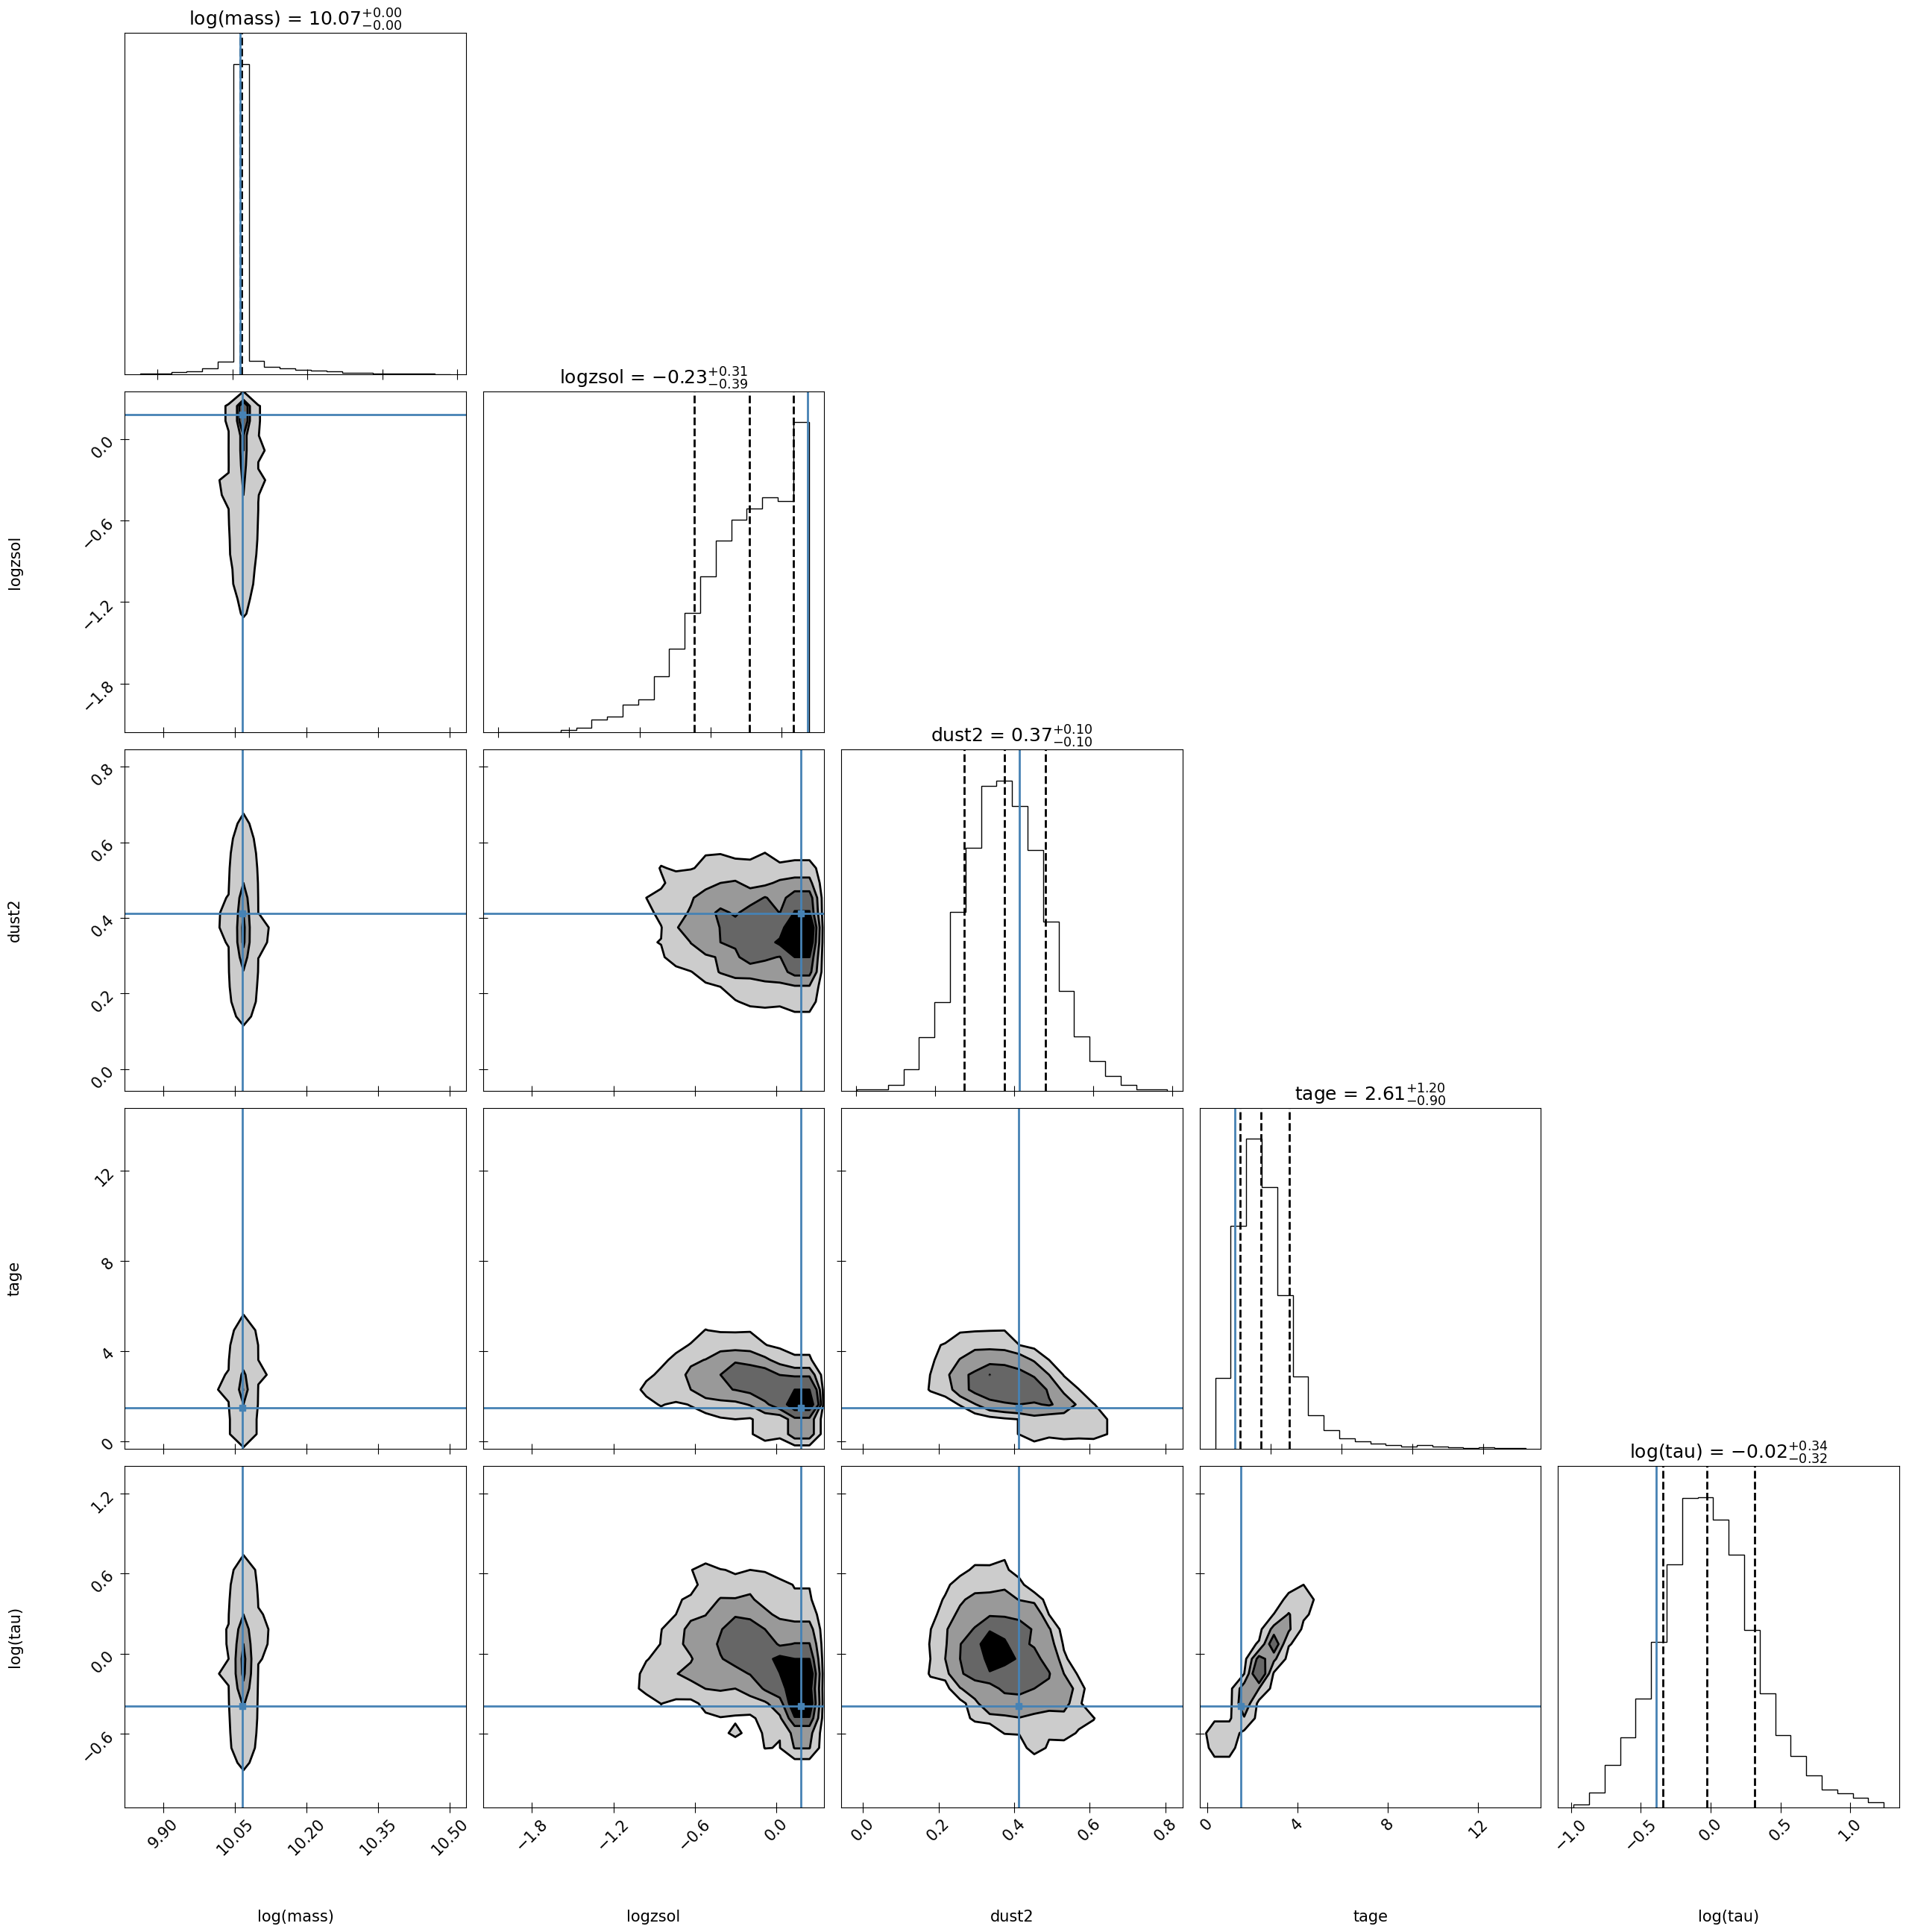

In [17]:
print('Optimization value: {}'.format(theta_max))
print('MAP value: {}'.format(theta_max))
cornerfig = reader.subcorner(result, start=0, thin=thin, truths=theta_max, 
                             fig=plt.subplots(5,5,figsize=(27,27))[0])

Feel free to edit this notebook, play around with different parameters, and try to get better fits if you'd like!